# Project Update
June 3rd, 2017

- [TCGA and GTEx Metadata](#TCGA-and-GTEx-Metadata)
- [Classifier Workflow](#Classifier-Workflow)
- [Classifiers](#Classifiers)
- [TETE Clustering](#TETE-Clustering)
- [Advancement](#A

## TCGA and GTEx Metadata

Finally found comprehensive metadata for both GTEx and TCGA, which enriches the available feature set. Manifest TSVs were obtained from [here](http://snaptron.cs.jhu.edu/data). Notebook of metadata processing is [here](https://github.com/jvivian/ipython_notebooks/blob/master/tcga-gtex-metadata/tcga-gtex-metadata.ipynb).

**Metadata Processing**
1. Read in TSVs
    1. TCGA: 858 columns
    2. GTEX: 301 columns
2. Select possibly interesting features using GSD (Graduate Student Descent)
3. Filter uninformative and spare features
4. Replace string "Nones" with NaNs
5. Group data by DTYPE (to separate out categorical and continuous data)
6. Find intersection of metadata features (which don't match so refer back to GSD)
    1. id - ID of sample
    2. reads - Number of reads in the sample
    3. size_MB - Size in MB of the sample
    4. platform - Sequencing platform (e.g. Illumina HiSeq)
    5. sex - Male / Female
    6. tissue - Tissue sample originated from
    7. seq_site - Sequencing center site (e.g. UNC, BI)
    8. weight - Weight in lbs
    9. height - Height in in
    10. mapped_reads - Number of mapped reads
    11. race - e.g. white, asian
    12. age - Age of patient
    13. qc - Converted a280 or RNA Integrity Number (RIN)
    14. dataset - TCGA or GTEx
7. Make appropriate conversions
    1. Convert bytes to MB for TCGA
    2. Convert years to birth to age (2010 - year of birth)
    3. Convert a260_a280 to a score similar to RIN
    4. Convert TCGA cm to in
8. Plot values to look for errors, outliers, and correlations
9. One-Hot-Encode all categorical variables (not being used as the classification vector)
10. Pull normalized gene expression values out of DESeq2 to use

### a260_a280 Conversion to RIN Range

By transforming a260 scores to the same range as RIN, a new feature that spans both GTEx and TCGA can be used for learning. 

A "perfect" a260_a280 score is 2.0 and general consensus suggests only using samples between ~1.8 - 2.2. RIN ranges from 0 to 10, with 10 being the highest score. GTEx advises not using samples with a RIN under 6. We can't find a converting factor through systems of equations, but since we know our cutoffs and maximum scores, we can model the conversion as a linear piecewise transformation.

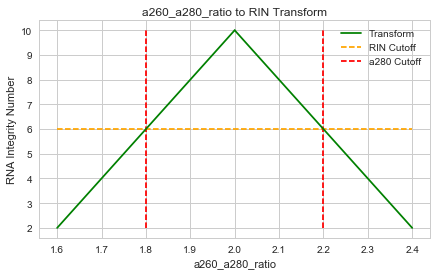

In [3]:
plt.figure(figsize=(7, 4))
x1 = [1.6, 1.7, 1.8, 1.9, 2.0]
x2 = [2.0, 2.1, 2.2, 2.3, 2.4]
plt.plot(x1, [20*x - 30 for x in x1], c='g', label='Transform')
plt.plot(x2, [-20*x + 50 for x in x2], c='g',)
plt.hlines(6, 1.6, 2.4, colors='orange', linestyles='--', label='RIN Cutoff')
plt.vlines(1.8, 2, 10, colors='red', linestyles='--', label='a280 Cutoff')
plt.vlines(2.2, 2, 10, colors='red', linestyles='--')
plt.xlabel('a260_a280_ratio')
plt.ylabel('RNA Integrity Number')
plt.title('a260_a280_ratio to RIN Transform')
plt.legend();

### Combined Manifest

In [4]:
df = pd.read_csv('../../../ipython_notebooks/tcga-gtex-metadata/combined_manifest.tsv', sep='\t', index_col=0)
df.head(2)

,id,reads,size_MB,platform,sex,tissue,seq_site,weight,height,mapped_reads,race,age,qc,dataset,tumor
TCGA-CD-8534-01,TCGA-CD-8534-01,240016440,14982.158203,Illumina HiSeq,male,Stomach,BCGSC,NaN,NaN,207116695.0,asian,40.0,0.0,tcga,yes
TCGA-ER-A19A-06,TCGA-ER-A19A-06,179705496,7383.316781,Illumina HiSeq,male,Skin,UNC,NaN,NaN,178311442.0,white,83.0,4.0,tcga,yes


### Pairwise Plot of Continuous Variables
Draw scatterplots for joint relationships and histograms for univariate distributions

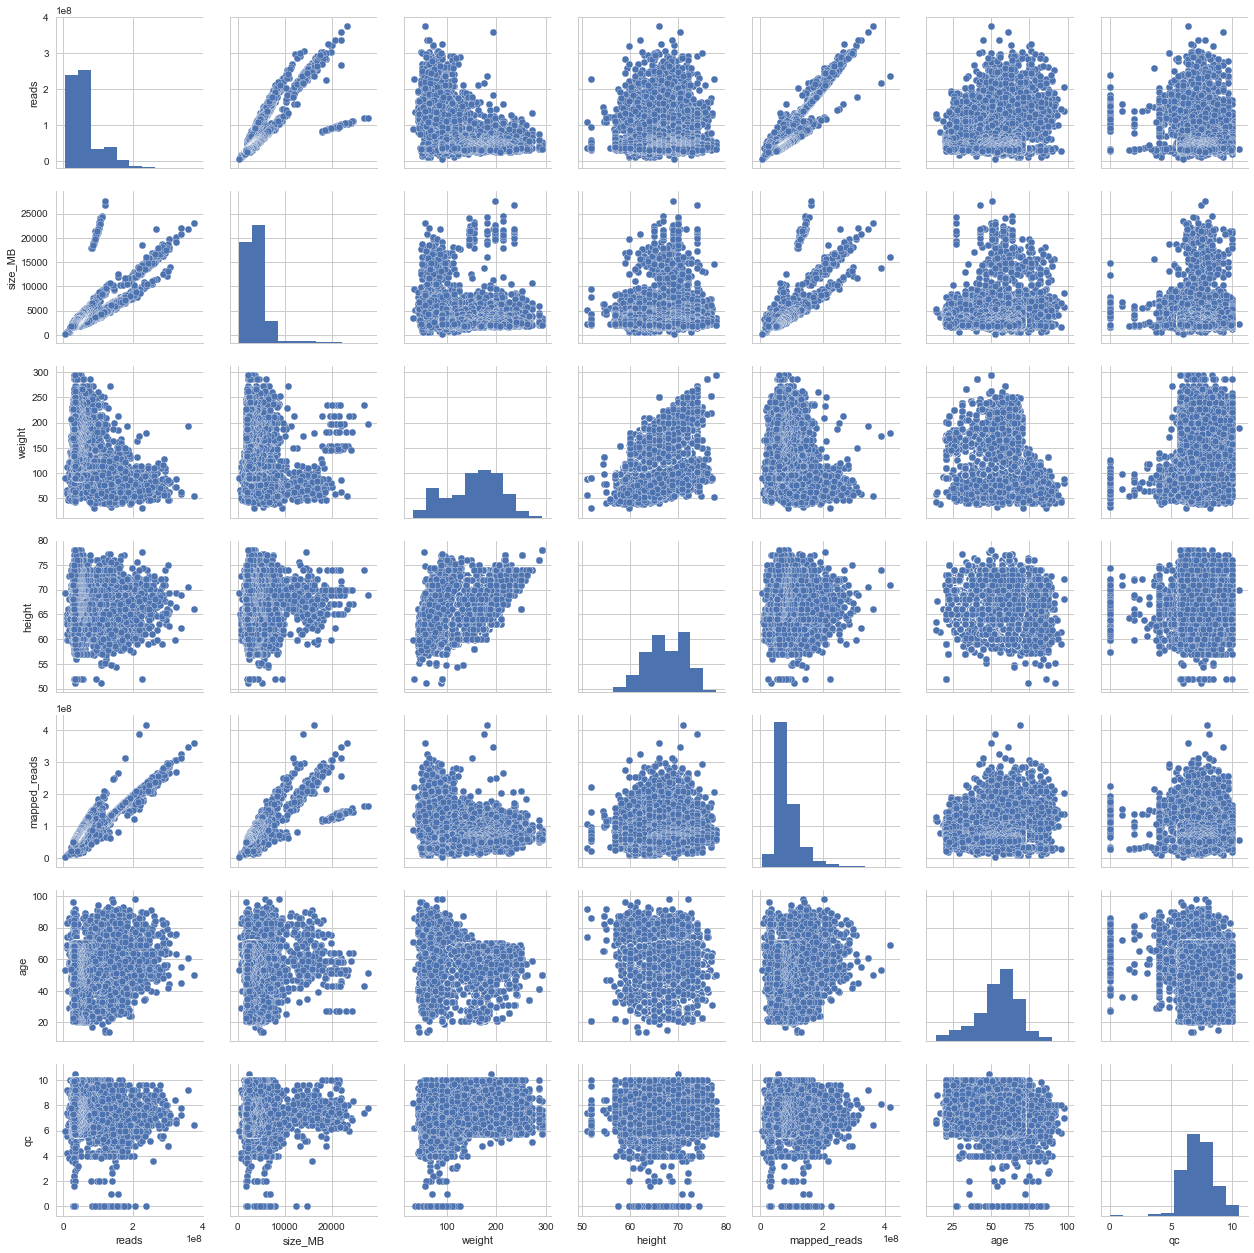

In [5]:
sns.pairplot(data = df[['reads', 'size_MB', 'weight', 'height', 'mapped_reads', 'age', 'qc']].dropna());

### Categorical Features

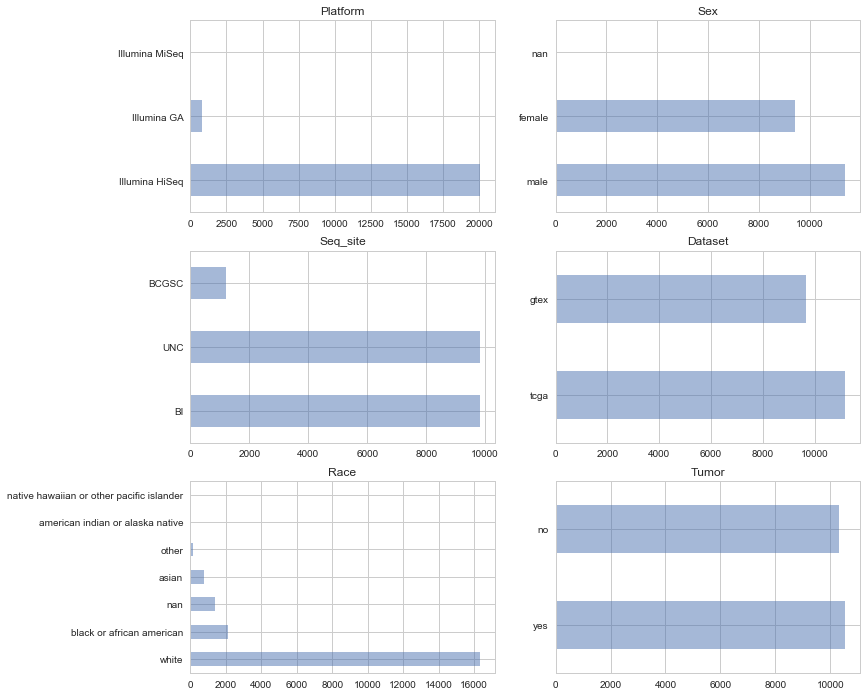

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax = ax.flatten()
for i, f in enumerate(['platform', 'sex', 'seq_site', 'dataset', 'race', 'tumor']):
    df[f].value_counts(dropna=False).plot(kind='barh', ax=ax[i], alpha=0.5)
    ax[i].set_title(f.capitalize())

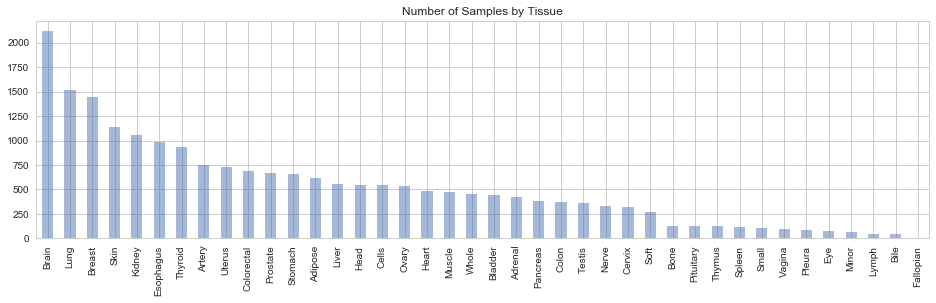

In [16]:
plt.figure(figsize=(16, 4))
df['tissue'].value_counts(dropna=False).plot(kind='bar', alpha=0.5)
plt.title('Number of Samples by Tissue');

### Categorical Biases
Categorical biases will lead to uninformative classification. For example, a dataset classifier would achieve almost 100% accuracy by only knowing the sequencing site.

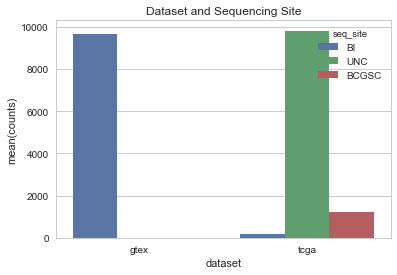

In [80]:
seq = pd.DataFrame()
seq['dataset'] = ['gtex', 'tcga', 'tcga', 'tcga']
seq['seq_site'] = ['BI', 'UNC', 'BCGSC', 'BI']
seq['counts'] = [9662, 9814, 1207, 169]
sns.barplot(data=seq, x='dataset', y='counts', hue='seq_site')
plt.title('Dataset and Sequencing Site');

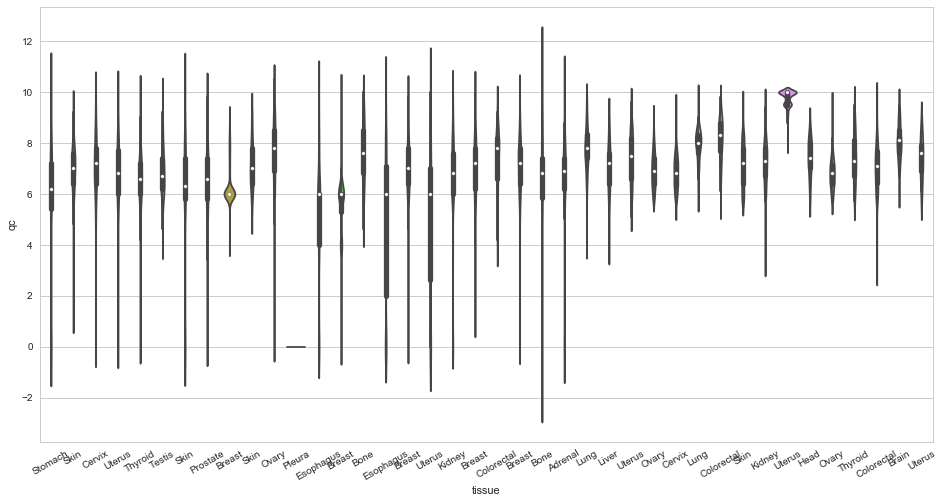

In [87]:
plt.figure(figsize=(16, 8))
g = sns.violinplot(data=df, x='tissue', y='qc')
g.set_xticklabels(df.tissue, rotation=30);

## Classifier Workflow

Generalize a workflow for classification that we can apply to questions generated from the combined metadata and gene expression data of TCGA and GTEx.

[Source code](https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/classifier_workflow/classifier_workflow.py) and [tests](https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/classifier_workflow/test/test_classifier_workflow.py) for the workflow. Depending on runtime performance as the dataset increases in size, this may be best adapted as a Toil workflow. 

<img src='wflow.png'>

## Classifiers

Gene expression count data is being normalized with DESeq2 (95 hours and running on 16 cores / 220G of RAM), which handles sequencing depth, variance dispersion shrinkage, and quantile normalization. 

**BLOCKED:** The expression matrix is ~20,000 by ~20,000, so just normalizationprocessing will likely take 1-2 weeks. In the interim I can do testing with standard `log2(x + 1)` normalization. My usual workbox is clogged with DESeq2 normalization, so I'll be spinning up some Openstack nodes to get this running.

Each classifier can potentionally be trained four different ways:
1. Train on all data, test on all data
2. Train on GTEx, test on TCGA tumor / normal
3. Train on TCGA normal, test on GTEx / tumor
4. Train on tumor, test on GTEx / TCGA normal

**Classifiers**
- Tissue Classifier
- Tumor Classifier
- Dataset Classifier
    - The accuracy of a dataset classifier is an indication of batch effect severity and can possibly provide insight into what form the batch effect is taking. 

Features that are strongly correlated with a predictive class can be naively learned from the Feature Importance TSV and pruned if considered uninformative or biased. 

## TETE Clustering

I got in touch with a couple professors who are writing a draft paper (with someone from Adobe) about an alternative to t-SNE that I'll be testing out for them on the TCGA / GTEx dataset:

ABSTRACT

We describe a new method called t-ETE for finding a low-dimensional embedding of a set of objects in Euclidean space.
We formulate the embedding problem as a joint ranking problem over a set of triplets, where each triplet captures the relative similarities between three objects in the set. By exploiting recent advances in robust ranking, t-ETE produces high-quality embeddings even in the presence of a significant amount of noise and better preserves local scale than known methods, such as t-STE and t-SNE. In particular, our method produces significantly better results than t-SNE on signature datasets while also being faster to compute.

## Advancement

I got the room booked with Tracie: E2-180 (Simularium) for you on July 19th from 10-1.

That leaves only 3 clerical tasks:
1. Providing notice of advancement [Deadline July 4th](https://ga.soe.ucsc.edu/node/401)
2. Turn in [Dissertation Reading Form](http://graddiv.ucsc.edu/current-students/pdfs/drc_nom.pdf)
3. Check E2-180 access, check with Tracie about remote setup for advancement. Ideally we can get a setup where Gunnar can see both the presentation and myself, and when it's time to move to discussion we can transfer over easily.

I've been trying to write almost every day and am about done with Aim 1. I'm working on restructuring Aim 2 a bit, but I feel like I have a lot of figures, notebooks, and a decent amount preliminary data. 

Read-only link to the $\LaTeX$ page: https://www.overleaf.com/read/cxhwpjttzgxc

## Production / Dev

- Code Review [#89](https://github.com/BD2KGenomics/toil-rnaseq/pull/89)
- Code Review [#90](https://github.com/BD2KGenomics/toil-rnaseq/pull/90)
- Code Review [#92](https://github.com/BD2KGenomics/toil-rnaseq/pull/92)
- Code Review [#93](https://github.com/BD2KGenomics/toil-rnaseq/pull/97)
- [Released 3.3.0](https://github.com/BD2KGenomics/toil-rnaseq/releases/tag/releases%2F3.3.0)
- Spent ~6-10 hours this week and last debugging production code, containers, etc. 
- Cherrypicking production fixes over to release branch in preparation for 3.3.1 release tomorrow. This should lockstep production's docker quay.io releases with the python version of the code. At the moment, production doesn't _appear_ to have any tests, so Jenkins CI hasn't been helpful in preventing breaking code changes being merged into the production code in the repository. 

In [90]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import pandas as pd
import numpy as np